In [1]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt

# Some pandas display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 500)

# Loading owid data to sql database

In [2]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [3]:
owid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=['date'], dayfirst = True, sep=',', skip_blank_lines = False)

In [4]:
#Input format: csv in which each row is a unique date, country pair and columns contain a lot of covid-related...
#...info for the given country on the given date.
#Output format: a sql table in which again each row is a unique date, country pair,but only The Netherlands,...
#... Italy and Japan, the countries of our interest, are included and only the columns containing information...,
#...relevant to our analysis is kept.

db_conn.execute("DROP TABLE IF EXISTS owid CASCADE;")
owid = owid[(owid.location == 'Italy') | (owid.location=='Japan') | (owid.location == 'Netherlands')]
toDrop = ['continent','total_deaths','new_deaths','new_deaths_smoothed','total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million','total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities','life_expectancy',
       'human_development_index', 'excess_mortality_cumulative_absolute',
       'excess_mortality_cumulative', 'excess_mortality',
       'excess_mortality_cumulative_per_million']
toDrop = [x for x in toDrop if x in owid.columns]
owid.drop(toDrop, axis = 1, inplace=True)
owid.to_sql("owid", db_conn, if_exists='replace')
df = pd.read_sql_table('owid', db_conn)
df

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,hospital_beds_per_thousand
0,101520,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
1,101521,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
2,101522,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
3,101523,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
4,101524,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,144342,NLD,Netherlands,2022-10-20,8498484.0,0.0,3244.714,485580.597,0.000,185.394,0.85,63.0,3.600,1113.0,63.594,75.0,4.285,1106.0,63.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2972,144343,NLD,Netherlands,2022-10-21,8505486.0,7002.0,2667.857,485980.673,400.076,152.434,0.76,56.0,3.200,1123.0,64.165,65.0,3.714,1114.0,63.651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2973,144344,NLD,Netherlands,2022-10-22,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32
2974,144345,NLD,Netherlands,2022-10-23,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32


In [5]:
pd.unique(owid['iso_code'])

array(['ITA', 'JPN', 'NLD'], dtype=object)

In [6]:
db_conn.execute("DROP VIEW IF EXISTS owidWY CASCADE;")
query = '''
CREATE OR REPLACE VIEW owidWY AS 
SELECT *,
CAST(EXTRACT(WEEK FROM date) AS int) AS week,
CAST(EXTRACT(YEAR FROM date) AS int) AS year
FROM owid
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM owidWY',db_conn)
df 

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,hospital_beds_per_thousand,week,year
0,101520,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,5,2020
1,101521,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,5,2020
2,101522,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,5,2020
3,101523,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,6,2020
4,101524,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.18,6,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,144342,NLD,Netherlands,2022-10-20,8498484.0,0.0,3244.714,485580.597,0.000,185.394,0.85,63.0,3.600,1113.0,63.594,75.0,4.285,1106.0,63.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,42,2022
2972,144343,NLD,Netherlands,2022-10-21,8505486.0,7002.0,2667.857,485980.673,400.076,152.434,0.76,56.0,3.200,1123.0,64.165,65.0,3.714,1114.0,63.651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,42,2022
2973,144344,NLD,Netherlands,2022-10-22,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,42,2022
2974,144345,NLD,Netherlands,2022-10-23,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.32,42,2022


# Loading covariants data to sql

In [7]:
#input format: json in which first level objects represent countries. Each country has attributes for..
#...weekly dates during the pandemic, the total number of analysed covid infection sequences during that week...
#...and attributes for number of sequences that were of a given variant during that week.
#output format: a sql table where each row is a unique country, date pair and there are columns for...
#... country_iso, date total sequences analysed and number of all sequences found. Only data for NLD, ITA...
#... and JPN is kept.

covarRaw = pd.read_json('https://raw.githubusercontent.com/hodcroftlab/covariants/07b0ea786205ad7269c09d46d2f7b13ef01b667e/cluster_tables/EUClusters_data.json')
dfs = []

for i in range(len(covarRaw.index)):
    country = covarRaw.index[i]
    if not country in ['Netherlands','Italy','Japan']:
        continue
    dtn = covarRaw['countries'][i]
    dtn['iso_code'] = coco.convert(country)
    df = pd.DataFrame.from_dict(dtn)
    df['date'] = pd.to_datetime(df['week'])
    df.drop('week',axis=1,inplace=True)
    dfs.append(df)
    
covarRaw = None
covar = pd.concat(dfs)


# Getting percentages instead of total

In [29]:
cols = list(covar)
#put the date and iso column to the front of the list
cols.insert(1, cols.pop(cols.index('date')))
cols.insert(2, cols.pop(cols.index('iso_code')))

covar = covar.loc[:, cols]

#create a column with the unclassified varients
covar['other/unknown_variants']= covar['total_sequences'] - covar.iloc[:,3:].sum(axis=1)

#instead of absulute valies we calculte 
columns_to_divide_by = covar.columns.values[3:]
covar.iloc[:,3:] = covar[columns_to_divide_by].div(covar.total_sequences, axis=0)

covar.head(5)

,total_sequences,date,iso_code,"20I (Alpha, V1)","20H (Beta, V2)","20J (Gamma, V3)",21A (Delta),21I (Delta),21J (Delta),21K (Omicron),21L (Omicron),22A (Omicron),22B (Omicron),22C (Omicron),22D (Omicron),21B (Kappa),21D (Eta),21F (Iota),21G (Lambda),21H (Mu),20B/S:732A,20E (EU1),21C (Epsilon),20A/S:439K,S:677H.Robin1,20A.EU2,20A/S:98F,20B/S:626S,20B/S:1122L,20A/S:126A,20C/S:80Y,other/unknown_variants
0,421,2020-04-27,JPN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.997625
1,117,2020-05-11,JPN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.991453
2,149,2020-05-25,JPN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.993289
3,191,2020-06-08,JPN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.994764
4,389,2020-06-22,JPN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.997429


In [9]:
db_conn.execute("DROP TABLE IF EXISTS covar CASCADE;")
covar.to_sql("covar", db_conn, if_exists='replace')

193

# Loading event cancel data to sql

In [10]:
#input format: csv in which rows consist of unique countries, columns consist of dates. Each entry... 
# ...represents the cancelation level for the given date in the given country
#output format: a sql table where each row is a unique country date pair, columns for country_iso (from our country selection of NLD,... 
# ...ITA and JPN), date and event cancellation level

eventsRaw = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/timeseries/c4m_restrictions_on_gatherings.csv", sep=',', skip_blank_lines = False)
eventsRaw.drop(['Unnamed: 0', 'country_name','region_code','region_name','jurisdiction'],axis=1,inplace=True)

dfs= []
 
for iso in ['NLD','JPN','ITA']:
    df = eventsRaw[eventsRaw['country_code']==iso]
    df.drop('country_code',axis=1,inplace=True)
    df= df.T
    df.columns = ['event_cancellation_level']
    df['date'] = pd.to_datetime(df.index)
    df['iso_code'] = iso
    dfs.append(df)

eventsRaw = None
events = pd.concat(dfs)
events
    

/tmp/ipykernel_2542/2797740475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)
/tmp/ipykernel_2542/2797740475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)
/tmp/ipykernel_2542/2797740475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('country_code',axis=1,inplace=True)


,event_cancellation_level,date,iso_code
01Jan2020,0.0,2020-01-01,NLD
02Jan2020,0.0,2020-01-02,NLD
03Jan2020,0.0,2020-01-03,NLD
04Jan2020,0.0,2020-01-04,NLD
05Jan2020,0.0,2020-01-05,NLD
...,...,...,...
14Oct2022,0.0,2022-10-14,ITA
15Oct2022,0.0,2022-10-15,ITA
16Oct2022,0.0,2022-10-16,ITA
17Oct2022,0.0,2022-10-17,ITA


In [11]:
db_conn.execute("DROP TABLE IF EXISTS events CASCADE;")
events.to_sql("events", db_conn, if_exists='replace')

66

# Joining all relevant data in single sql view

In [12]:
#Joining variant data to owid data
db_conn.execute("DROP VIEW IF EXISTS owidcovar CASCADE;")
query = '''
CREATE OR REPLACE VIEW owidcovar AS 
SELECT 
    owidWY.*, "total_sequences", "20I (Alpha, V1)", "20H (Beta, V2)", "20J (Gamma, V3)", "21A (Delta)", 
    "21I (Delta)", "21J (Delta)", "21K (Omicron)", "21L (Omicron)", "22A (Omicron)", "22B (Omicron)", "22C (Omicron)", 
    "22D (Omicron)", "21B (Kappa)", "21D (Eta)", "21F (Iota)", "21G (Lambda)", "21H (Mu)", "20B/S:732A", "20E (EU1)", 
    "21C (Epsilon)", "20A/S:439K", "S:677H.Robin1", "20A.EU2", "20A/S:98F", "20B/S:626S", "20B/S:1122L", "20A/S:126A", "20C/S:80Y", "other/unknown_variants"
FROM owidWY
LEFT JOIN covar ON (owidWY.date = covar.date AND owidWY.iso_code = covar.iso_code);
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM owidcovar',db_conn)
# df.head()

In [32]:
#Joining event cancellation data to owid and variant data
db_conn.execute("DROP VIEW IF EXISTS all_relevant CASCADE;")
query = '''
CREATE OR REPLACE VIEW all_relevant AS 
SELECT 
    owidcovar.*, event_cancellation_level
FROM owidcovar
LEFT JOIN events ON (owidcovar.date = events.date AND owidcovar.iso_code = events.iso_code);
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM all_relevant',db_conn)
df

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,...,21J (Delta),21K (Omicron),21L (Omicron),22A (Omicron),22B (Omicron),22C (Omicron),22D (Omicron),21B (Kappa),21D (Eta),21F (Iota),21G (Lambda),21H (Mu),20B/S:732A,20E (EU1),21C (Epsilon),20A/S:439K,S:677H.Robin1,20A.EU2,20A/S:98F,20B/S:626S,20B/S:1122L,20A/S:126A,20C/S:80Y,other/unknown_variants,event_cancellation_level
0,101520,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,101521,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,101522,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,101523,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,101524,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,144342,NLD,Netherlands,2022-10-20,8498484.0,0.0,3244.714,485580.597,0.000,185.394,0.85,63.0,3.600,1113.0,63.594,75.0,4.285,1106.0,63.194,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2972,144343,NLD,Netherlands,2022-10-21,8505486.0,7002.0,2667.857,485980.673,400.076,152.434,0.76,56.0,3.200,1123.0,64.165,65.0,3.714,1114.0,63.651,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2973,144344,NLD,Netherlands,2022-10-22,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2974,144345,NLD,Netherlands,2022-10-23,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Creating an interpolated df for analysis

In [48]:
#input the original df and the the columns that you want to be interpolated.
#returns a the original df with interpolated columns
def interpolation(df, columns_to_be_interpolated):
    
    
    #we only interpolated between values not before or after, therefor the limit_direction is both
    #we want to our interpolate limit to be two weeks
    remaining_columns = [elem for elem in df.columns.values.tolist() if elem not in columns_to_be_interpolated]
    remaining_columns_df = df[remaining_columns] 
    df_to_be_interpolated = df[columns_to_be_interpolated]
    
    dfRes = df_to_be_interpolated.interpolate(method ='linear', limit_direction ='both', limit = 21)

    dfRes = pd.concat([remaining_columns_df, dfRes], axis=1)
    
    return df


In [47]:
JPN_df = df.loc[df['iso_code'] == 'JPN']
columns_to_be_interpolated_JPN = ['icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 
"total_sequences", "20I (Alpha, V1)", "20H (Beta, V2)", "20J (Gamma, V3)", "21A (Delta)", 
"21I (Delta)", "21J (Delta)", "21K (Omicron)", "21L (Omicron)", "22A (Omicron)", "22B (Omicron)", "22C (Omicron)", 
"22D (Omicron)", "21B (Kappa)", "21D (Eta)", "21F (Iota)", "21G (Lambda)", "21H (Mu)", "20B/S:732A", "20E (EU1)", 
"21C (Epsilon)", "20A/S:439K", "S:677H.Robin1", "20A.EU2", "20A/S:98F", "20B/S:626S", "20B/S:1122L", "20A/S:126A", "20C/S:80Y", "other/unknown_variants"]

JPN_df_interpolated = interpolation(JPN_df, columns_to_be_interpolated_JPN)

ITA_df = df.loc[df['iso_code'] == 'ITA']
ITA_df_interpolated = interpolation(ITA_df, columns_to_be_interpolated_JPN[5:])

columns = ['total_vaccinations_per_hundred','people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred','total_boosters_per_hundred', 
           'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million',
           'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','total_boosters']

NLD_df = df.loc[df['iso_code'] == 'NLD']

NLD_df_interpolated = interpolation(NLD_df, columns + columns_to_be_interpolated_JPN)


# joining the interpolated data together

In [50]:
#merging the interpolated datasets per country
df_interpolated = pd.concat([ITA_df_interpolated, JPN_df_interpolated, NLD_df_interpolated], ignore_index=False)

#merging the interpolated data frame with the old one to create on large dataframes
total_df  = pd.merge(df, df_interpolated.add_suffix('_inter'), left_on=['date','iso_code'],right_on = ['date_inter','iso_code_inter'], how='left')
total_df

,index,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,...,21J (Delta)_inter,21K (Omicron)_inter,21L (Omicron)_inter,22A (Omicron)_inter,22B (Omicron)_inter,22C (Omicron)_inter,22D (Omicron)_inter,21B (Kappa)_inter,21D (Eta)_inter,21F (Iota)_inter,21G (Lambda)_inter,21H (Mu)_inter,20B/S:732A_inter,20E (EU1)_inter,21C (Epsilon)_inter,20A/S:439K_inter,S:677H.Robin1_inter,20A.EU2_inter,20A/S:98F_inter,20B/S:626S_inter,20B/S:1122L_inter,20A/S:126A_inter,20C/S:80Y_inter,other/unknown_variants_inter,event_cancellation_level_inter
0,101520,ITA,Italy,2020-01-31,2.0,2.0,NaN,0.034,0.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,101521,ITA,Italy,2020-02-01,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,101522,ITA,Italy,2020-02-02,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,101523,ITA,Italy,2020-02-03,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,101524,ITA,Italy,2020-02-04,2.0,0.0,NaN,0.034,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,144342,NLD,Netherlands,2022-10-20,8498484.0,0.0,3244.714,485580.597,0.000,185.394,0.85,63.0,3.600,1113.0,63.594,75.0,4.285,1106.0,63.194,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2972,144343,NLD,Netherlands,2022-10-21,8505486.0,7002.0,2667.857,485980.673,400.076,152.434,0.76,56.0,3.200,1123.0,64.165,65.0,3.714,1114.0,63.651,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2973,144344,NLD,Netherlands,2022-10-22,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2974,144345,NLD,Netherlands,2022-10-23,8505486.0,0.0,2667.857,485980.673,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#pushing the interpolated df to SQL
db_conn.execute("DROP TABLE IF EXISTS total_df CASCADE;")
total_df.to_sql("total_df", db_conn, if_exists='replace')

976

# Creating views for success factors

In [19]:
#getting the relevant kpi data for cases (excluding variant distribution for now)
db_conn.execute("DROP VIEW IF EXISTS cases CASCADE;")
query = '''
CREATE OR REPLACE VIEW cases AS 
SELECT iso_code, date,new_cases_per_million, new_cases_smoothed_per_million, reproduction_rate
FROM all_relevant
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM cases',db_conn)
df

,iso_code,date,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate
0,JPN,2020-01-22,NaN,NaN,NaN
1,JPN,2020-01-23,0.000,NaN,NaN
2,JPN,2020-01-24,0.000,NaN,NaN
3,JPN,2020-01-25,0.000,NaN,NaN
4,JPN,2020-01-26,0.016,NaN,NaN
...,...,...,...,...,...
2971,JPN,2022-10-23,247.752,268.226,NaN
2972,NLD,2022-10-23,0.000,152.434,NaN
2973,ITA,2022-10-24,195.897,592.422,NaN
2974,JPN,2022-10-24,135.235,269.922,NaN


In [20]:
#getting the relevant kpi data for cases (including variant distribution)
db_conn.execute("DROP VIEW IF EXISTS casesplus CASCADE;")
query = '''
CREATE OR REPLACE VIEW casesplus AS 
SELECT iso_code, date,new_cases_per_million, new_cases_smoothed_per_million, reproduction_rate,
    "total_sequences", "20I (Alpha, V1)", "20H (Beta, V2)", "20J (Gamma, V3)", "21A (Delta)", 
    "21I (Delta)", "21J (Delta)", "21K (Omicron)", "21L (Omicron)", "22A (Omicron)", "22B (Omicron)", "22C (Omicron)", 
    "22D (Omicron)", "21B (Kappa)", "21D (Eta)", "21F (Iota)", "21G (Lambda)", "21H (Mu)", "20B/S:732A", "20E (EU1)", 
    "21C (Epsilon)", "20A/S:439K", "S:677H.Robin1", "20A.EU2", "20A/S:98F", "20B/S:626S", "20B/S:1122L", "20A/S:126A", "20C/S:80Y"
FROM all_relevant
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM casesplus',db_conn)
df

,iso_code,date,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate,total_sequences,"20I (Alpha, V1)","20H (Beta, V2)","20J (Gamma, V3)",21A (Delta),21I (Delta),21J (Delta),21K (Omicron),21L (Omicron),22A (Omicron),22B (Omicron),22C (Omicron),22D (Omicron),21B (Kappa),21D (Eta),21F (Iota),21G (Lambda),21H (Mu),20B/S:732A,20E (EU1),21C (Epsilon),20A/S:439K,S:677H.Robin1,20A.EU2,20A/S:98F,20B/S:626S,20B/S:1122L,20A/S:126A,20C/S:80Y
0,JPN,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JPN,2020-01-23,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JPN,2020-01-24,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JPN,2020-01-25,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JPN,2020-01-26,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,JPN,2022-10-23,247.752,268.226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2972,NLD,2022-10-23,0.000,152.434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2973,ITA,2022-10-24,195.897,592.422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2974,JPN,2022-10-24,135.235,269.922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#getting the relevant kpi data for vaccinations
query = '''
CREATE OR REPLACE VIEW vaccinations AS 
SELECT iso_code, date, people_fully_vaccinated_per_hundred, total_boosters_per_hundred,new_vaccinations_smoothed_per_million
FROM all_relevant
'''
db_conn.execute(query)
df =pd.read_sql('SELECT * FROM vaccinations',db_conn)
df

,iso_code,date,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million
0,JPN,2020-01-22,NaN,NaN,NaN
1,JPN,2020-01-23,NaN,NaN,NaN
2,JPN,2020-01-24,NaN,NaN,NaN
3,JPN,2020-01-25,NaN,NaN,NaN
4,JPN,2020-01-26,NaN,NaN,NaN
...,...,...,...,...,...
2971,JPN,2022-10-23,82.58,98.01,1828.0
2972,NLD,2022-10-23,NaN,NaN,NaN
2973,ITA,2022-10-24,80.98,74.76,685.0
2974,JPN,2022-10-24,82.59,98.11,1768.0


In [22]:
#getting the relevant kpi data for hospitalizations
db_conn.execute("DROP VIEW IF EXISTS hospitalizations, weeklyHos CASCADE;")
query = '''
CREATE OR REPLACE VIEW hospitalizations AS 
SELECT all_relevant.iso_code, date, icu_patients_per_million, weekly_icu_admissions_per_million, hosp_patients_per_million
FROM all_relevant
ORDER BY all_relevant.iso_code ASC, date ASC
'''
db_conn.execute(query)
df = pd.read_sql('SELECT * FROM hospitalizations',db_conn)
df

,iso_code,date,icu_patients_per_million,weekly_icu_admissions_per_million,hosp_patients_per_million
0,ITA,2020-01-31,NaN,NaN,NaN
1,ITA,2020-02-01,NaN,NaN,NaN
2,ITA,2020-02-02,NaN,NaN,NaN
3,ITA,2020-02-03,NaN,NaN,NaN
4,ITA,2020-02-04,NaN,NaN,NaN
...,...,...,...,...,...
2971,NLD,2022-10-20,3.600,4.285,63.594
2972,NLD,2022-10-21,3.200,3.714,64.165
2973,NLD,2022-10-22,NaN,NaN,NaN
2974,NLD,2022-10-23,NaN,NaN,NaN


# Plotting the data simply to increase data understanding

In [23]:
def simplePlot(db_conn,isoCode, factor, lastN=-1):
    df = pd.read_sql('SELECT * FROM ' + factor,db_conn)
    df = df[df.iso_code==isoCode]
    if lastN > 0:
        df = df.tail(lastN)
    kpis = [x for x in df.columns if not x in ['iso_code','date'] ]
    for kpi in kpis:
        print(kpi)
        plt.plot(df.index,kpi,data=df)
        plt.title(kpi + ' in ' + isoCode)
        plt.xticks(rotation=90)
        plt.show()

icu_patients_per_million


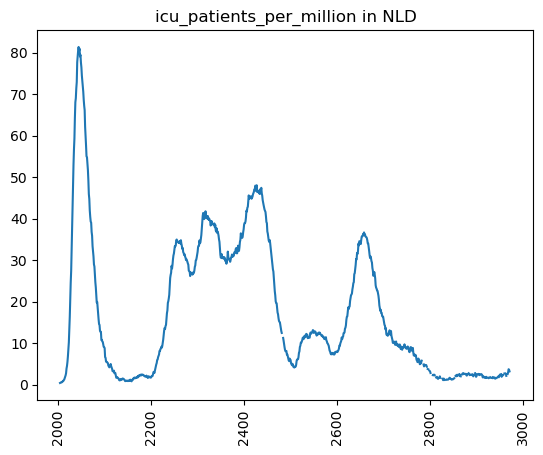

weekly_icu_admissions_per_million


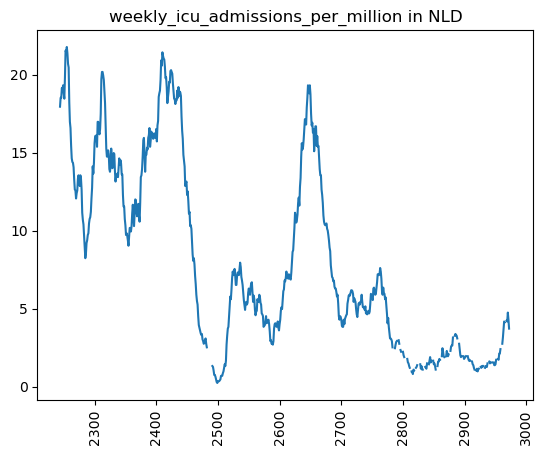

hosp_patients_per_million


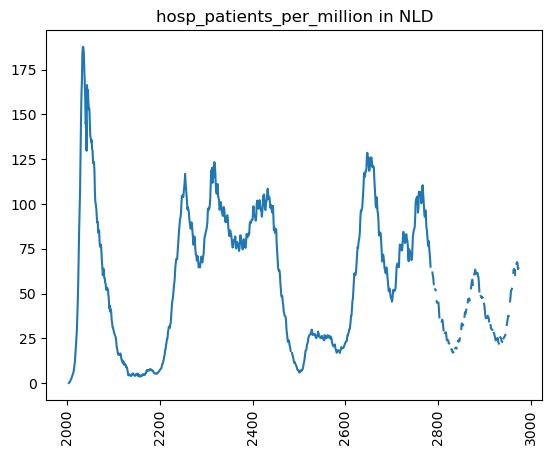

icu_patients_per_million


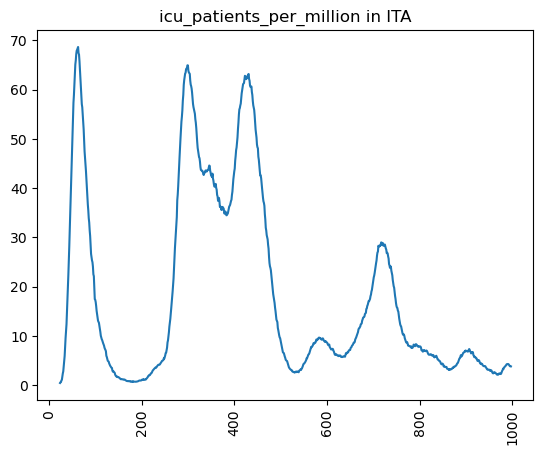

weekly_icu_admissions_per_million


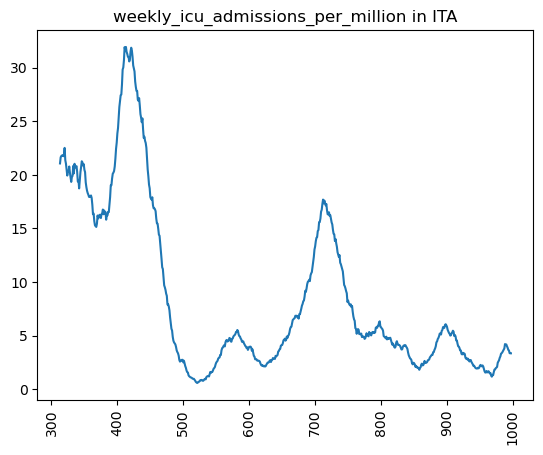

hosp_patients_per_million


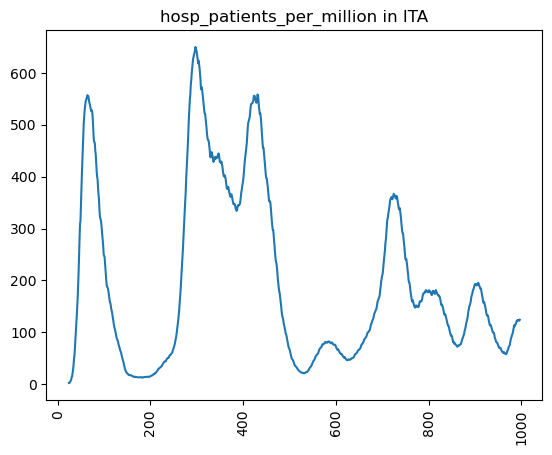

icu_patients_per_million


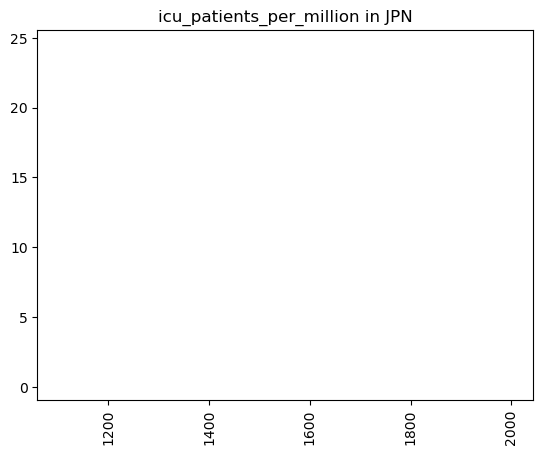

weekly_icu_admissions_per_million


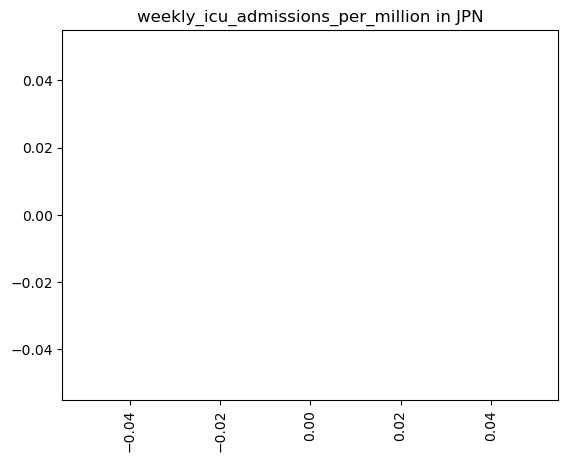

hosp_patients_per_million


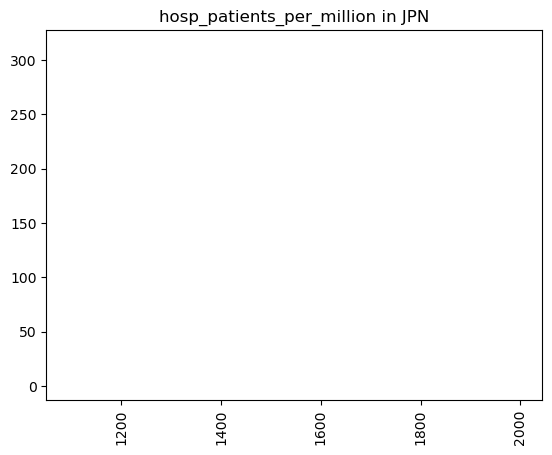

In [24]:
lastN = 2000
simplePlot(db_conn,'NLD','hospitalizations',lastN)
simplePlot(db_conn,'ITA','hospitalizations',lastN)
simplePlot(db_conn,'JPN','hospitalizations',lastN)

new_cases_per_million


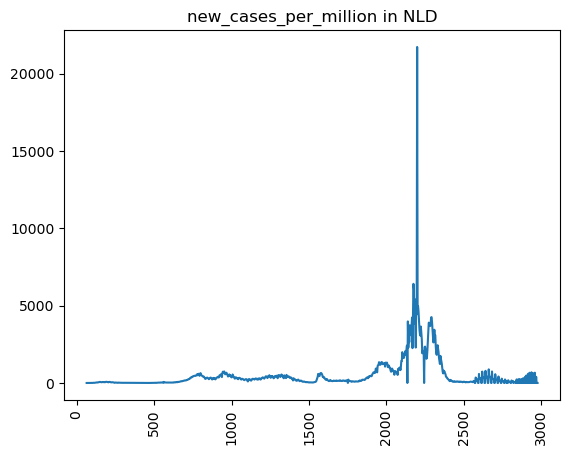

new_cases_smoothed_per_million


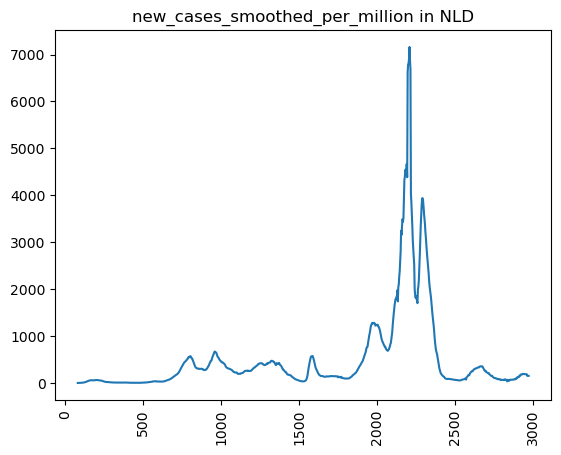

reproduction_rate


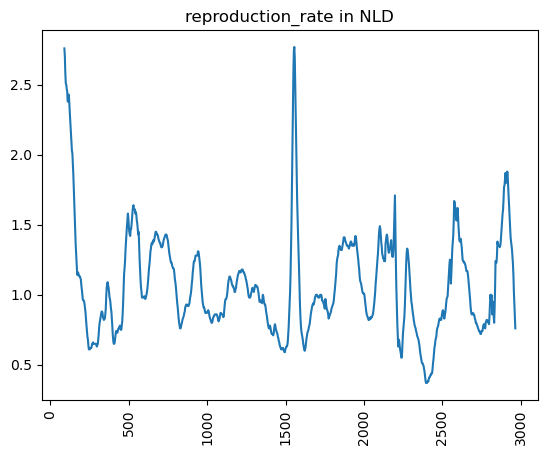

new_cases_per_million


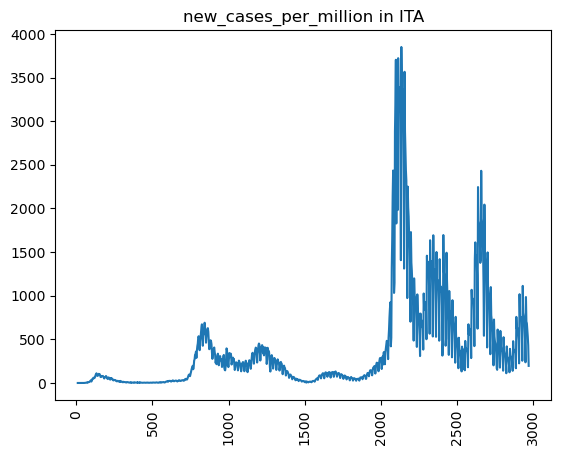

new_cases_smoothed_per_million


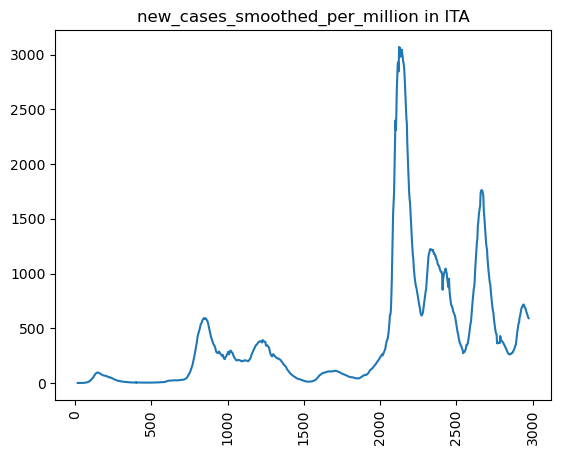

reproduction_rate


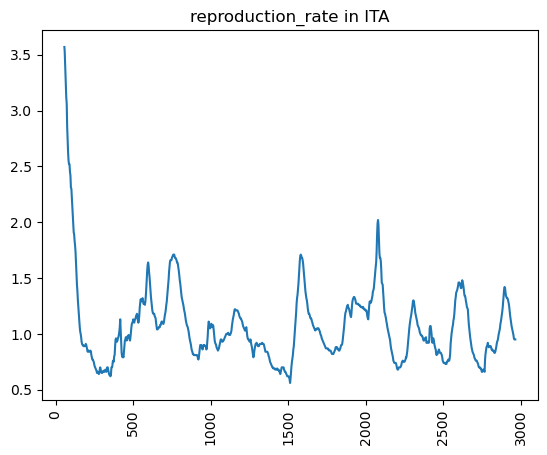

new_cases_per_million


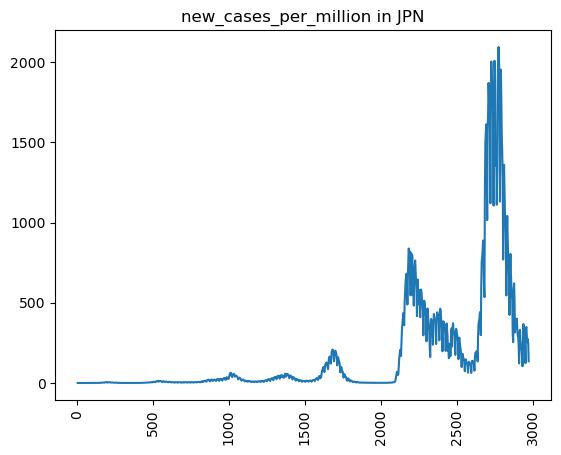

new_cases_smoothed_per_million


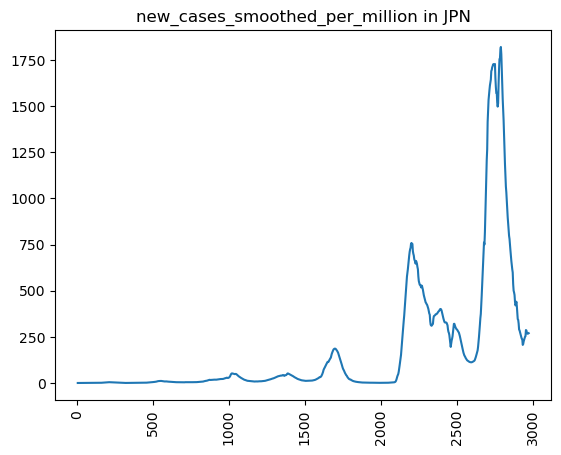

reproduction_rate


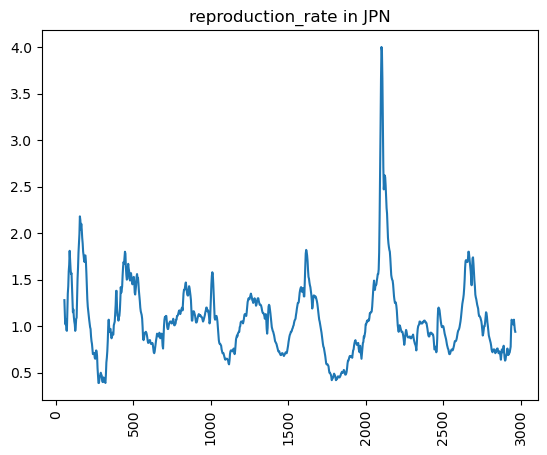

In [25]:
lastN = 1000
simplePlot(db_conn,'NLD','cases',lastN)
simplePlot(db_conn,'ITA','cases',lastN)
simplePlot(db_conn,'JPN','cases',lastN)

people_fully_vaccinated_per_hundred


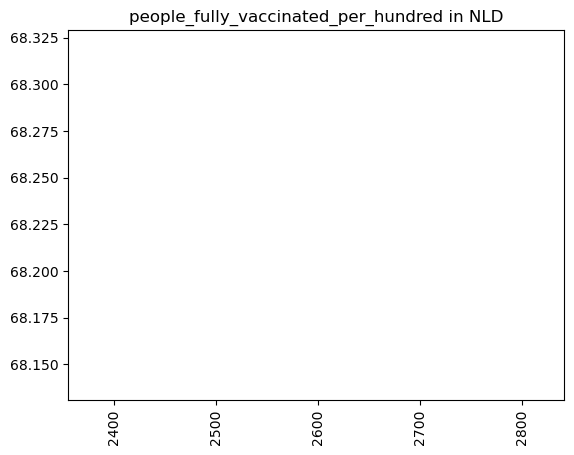

total_boosters_per_hundred


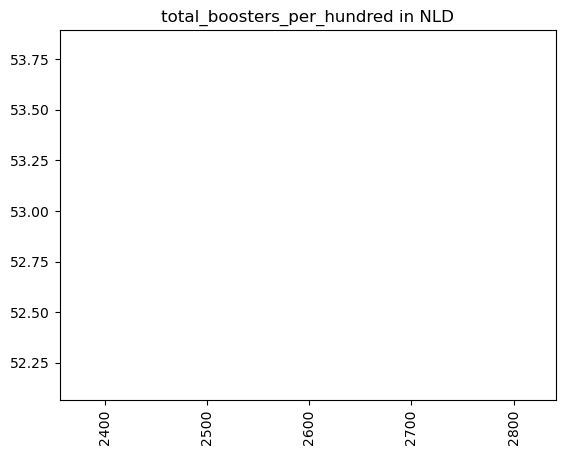

new_vaccinations_smoothed_per_million


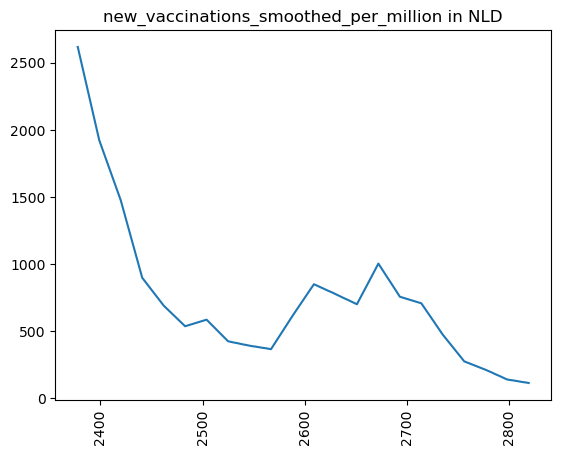

people_fully_vaccinated_per_hundred


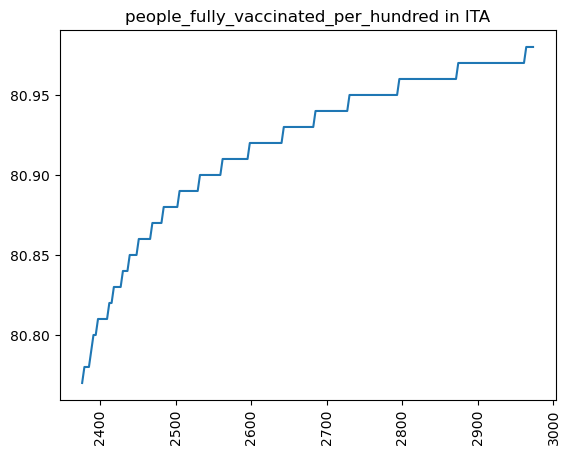

total_boosters_per_hundred


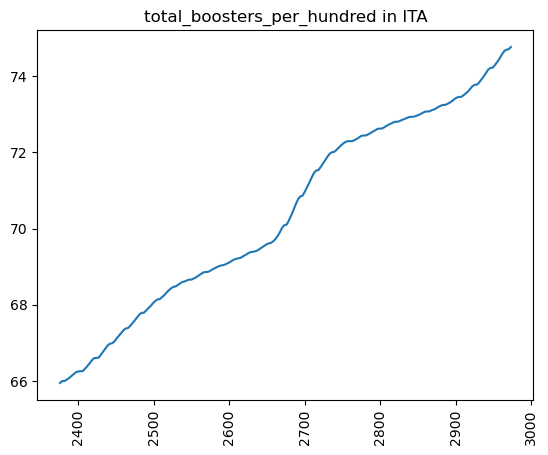

new_vaccinations_smoothed_per_million


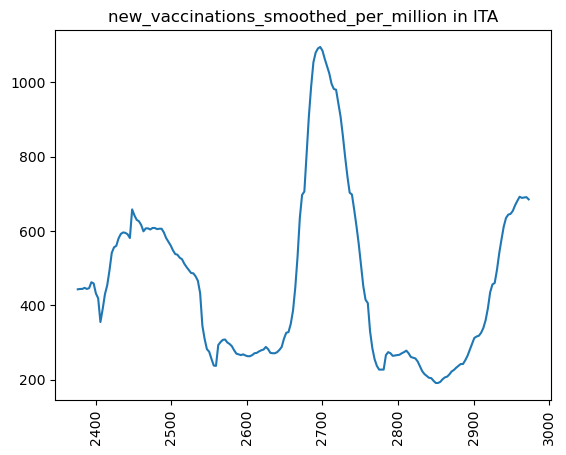

people_fully_vaccinated_per_hundred


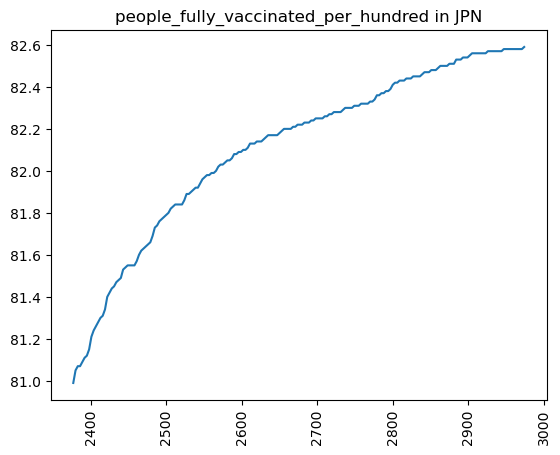

total_boosters_per_hundred


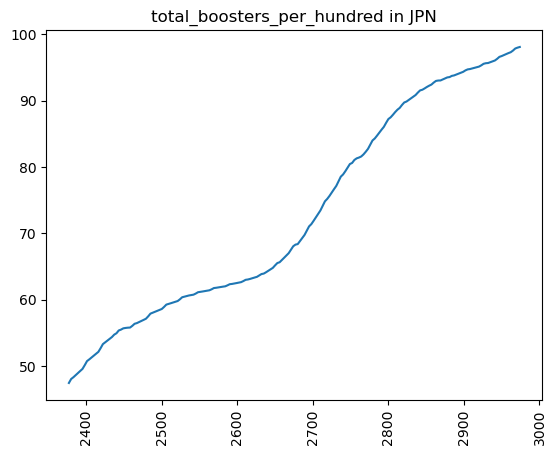

new_vaccinations_smoothed_per_million


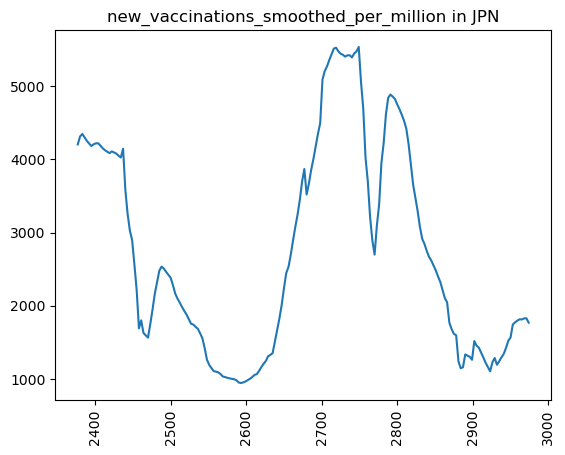

In [26]:
lastN = 200
simplePlot(db_conn,'NLD','vaccinations',lastN)
simplePlot(db_conn,'ITA','vaccinations',lastN)
simplePlot(db_conn,'JPN','vaccinations',lastN)